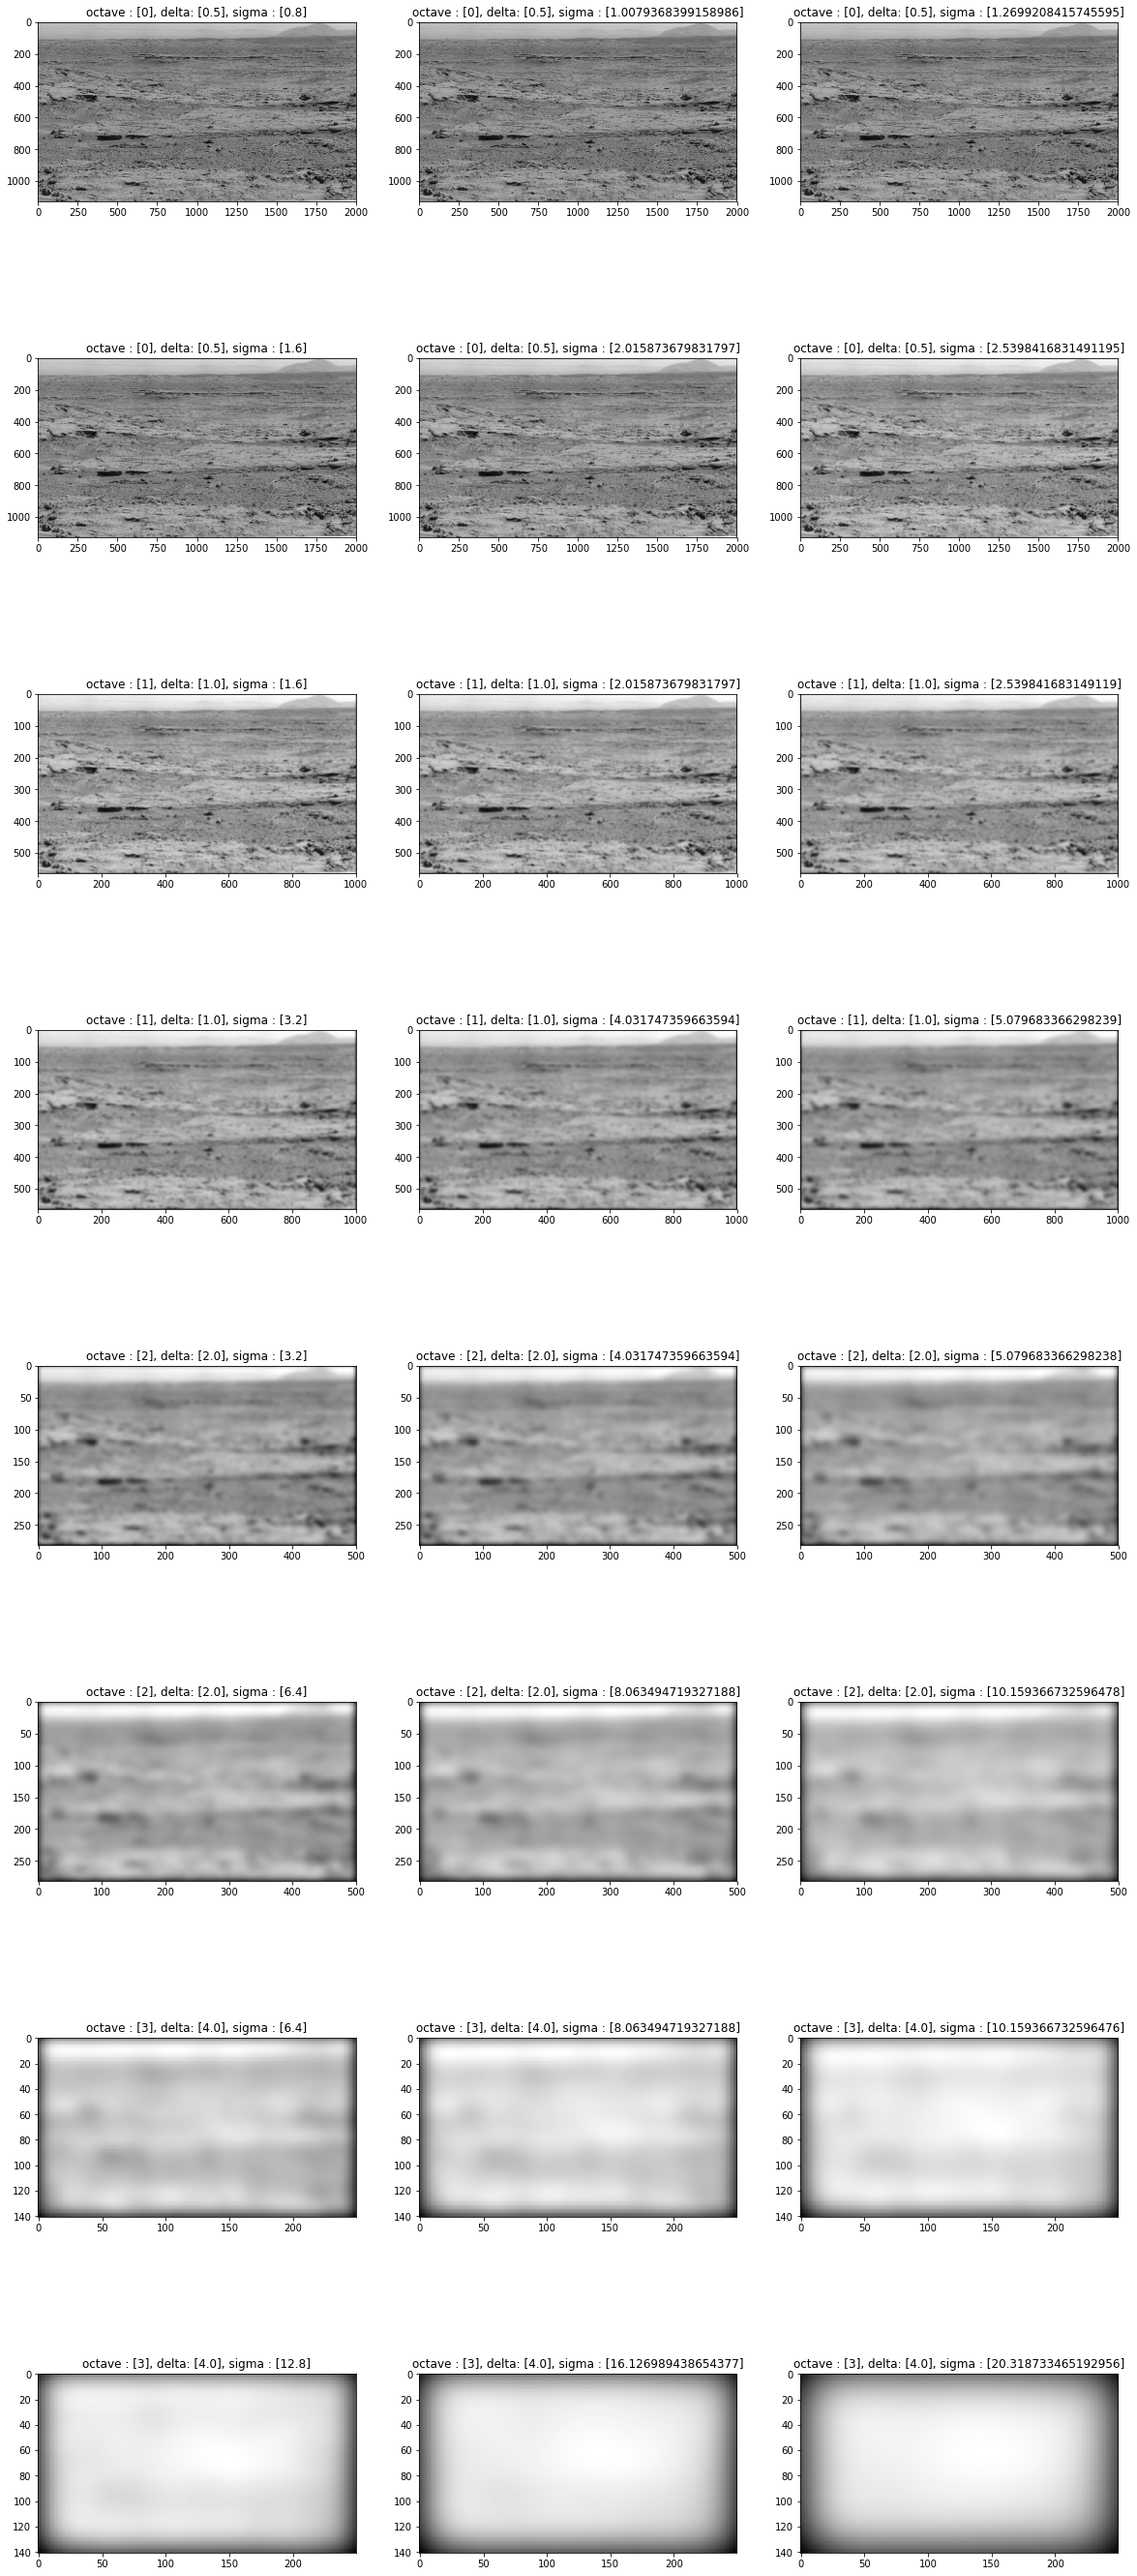

In [1]:
%matplotlib inline

import matplotlib
import cv2
import imutils
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from PIL import Image
from collections import namedtuple
from IPython.core.display import display, HTML

# default values
sigma_min = 0.8
n_spo = 3
delta_min = 0.5
n_oct = 4

def show_graysacle_img(img, title, hide_axis=True):
    plt.figure(figsize=(20,10))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    if hide_axis:
        plt.axis('off')
    plt.show();

#
# fspecial gausian mask
# obtenu a :
# https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python
#
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def differenceDeGaussiennes(img, nscales, noctave):
    nsca = nscales + 3  # 3 extra images in the stack, 1 for dog computation and 2 for 3d discrete extrema definition
    
    octaves = []
    dog = []
    
    sigmas = np.zeros(shape=(noctave, nsca))
    deltas = np.zeros(shape=noctave)
    deltas[0] = delta_min
    for i in range(1, noctave):
        deltas[i] = deltas[i - 1] * 2
    
    
    for i in range(noctave):
        octaves.append([])
        if deltas[i] < 1:
            img = cv2.pyrUp(img)
        else:
            img = cv2.pyrDown(img)
            
        for j in range(nsca):
            sigmas[i][j] = (deltas[i] / delta_min) * sigma_min * (2 ** (j / nscales))
            octaves[i].append(img)
    
    for i in range(noctave):
        for j in range(nsca):
            sigma = sigmas[i][j]
            dim_msk = np.ceil(sigma * 6)
            if(dim_msk % 2 == 0):
                dim_msk += 1
            msk = matlab_style_gauss2D((dim_msk, dim_msk), sigma)
            octaves[i][j] = signal.convolve2d(octaves[i][j], msk, mode="same")
    
    for i in range(noctave):
        dog.append([])
        for j in range(nsca - 1):
            dog[i].append(octaves[i][j + 1] - octaves[i][j])
            
    return (octaves, sigmas, dog, deltas)

img = cv2.imread('droite.jpg', cv2.IMREAD_GRAYSCALE)
octaves, sigmas, dog, deltas = differenceDeGaussiennes(img, n_spo, n_oct)

display(HTML('<h1>Q2. Pyramide de gaussiennes</h1>'))
fig = plt.figure(figsize=(20,50))
count = 0
for i in range(n_oct):
    for j in range(n_spo + 3):
        title = "octave : [" + str(i) + "], delta: [" + str(deltas[i]) + "], sigma : [" + str(sigmas[i][j]) + "]"
        sub = fig.add_subplot(n_oct * 2, int(np.ceil((n_spo + 3) / 2)), count + 1)
        sub.set_title(title)
        sub.imshow(octaves[i][j], interpolation='nearest', cmap='gray')
        count += 1


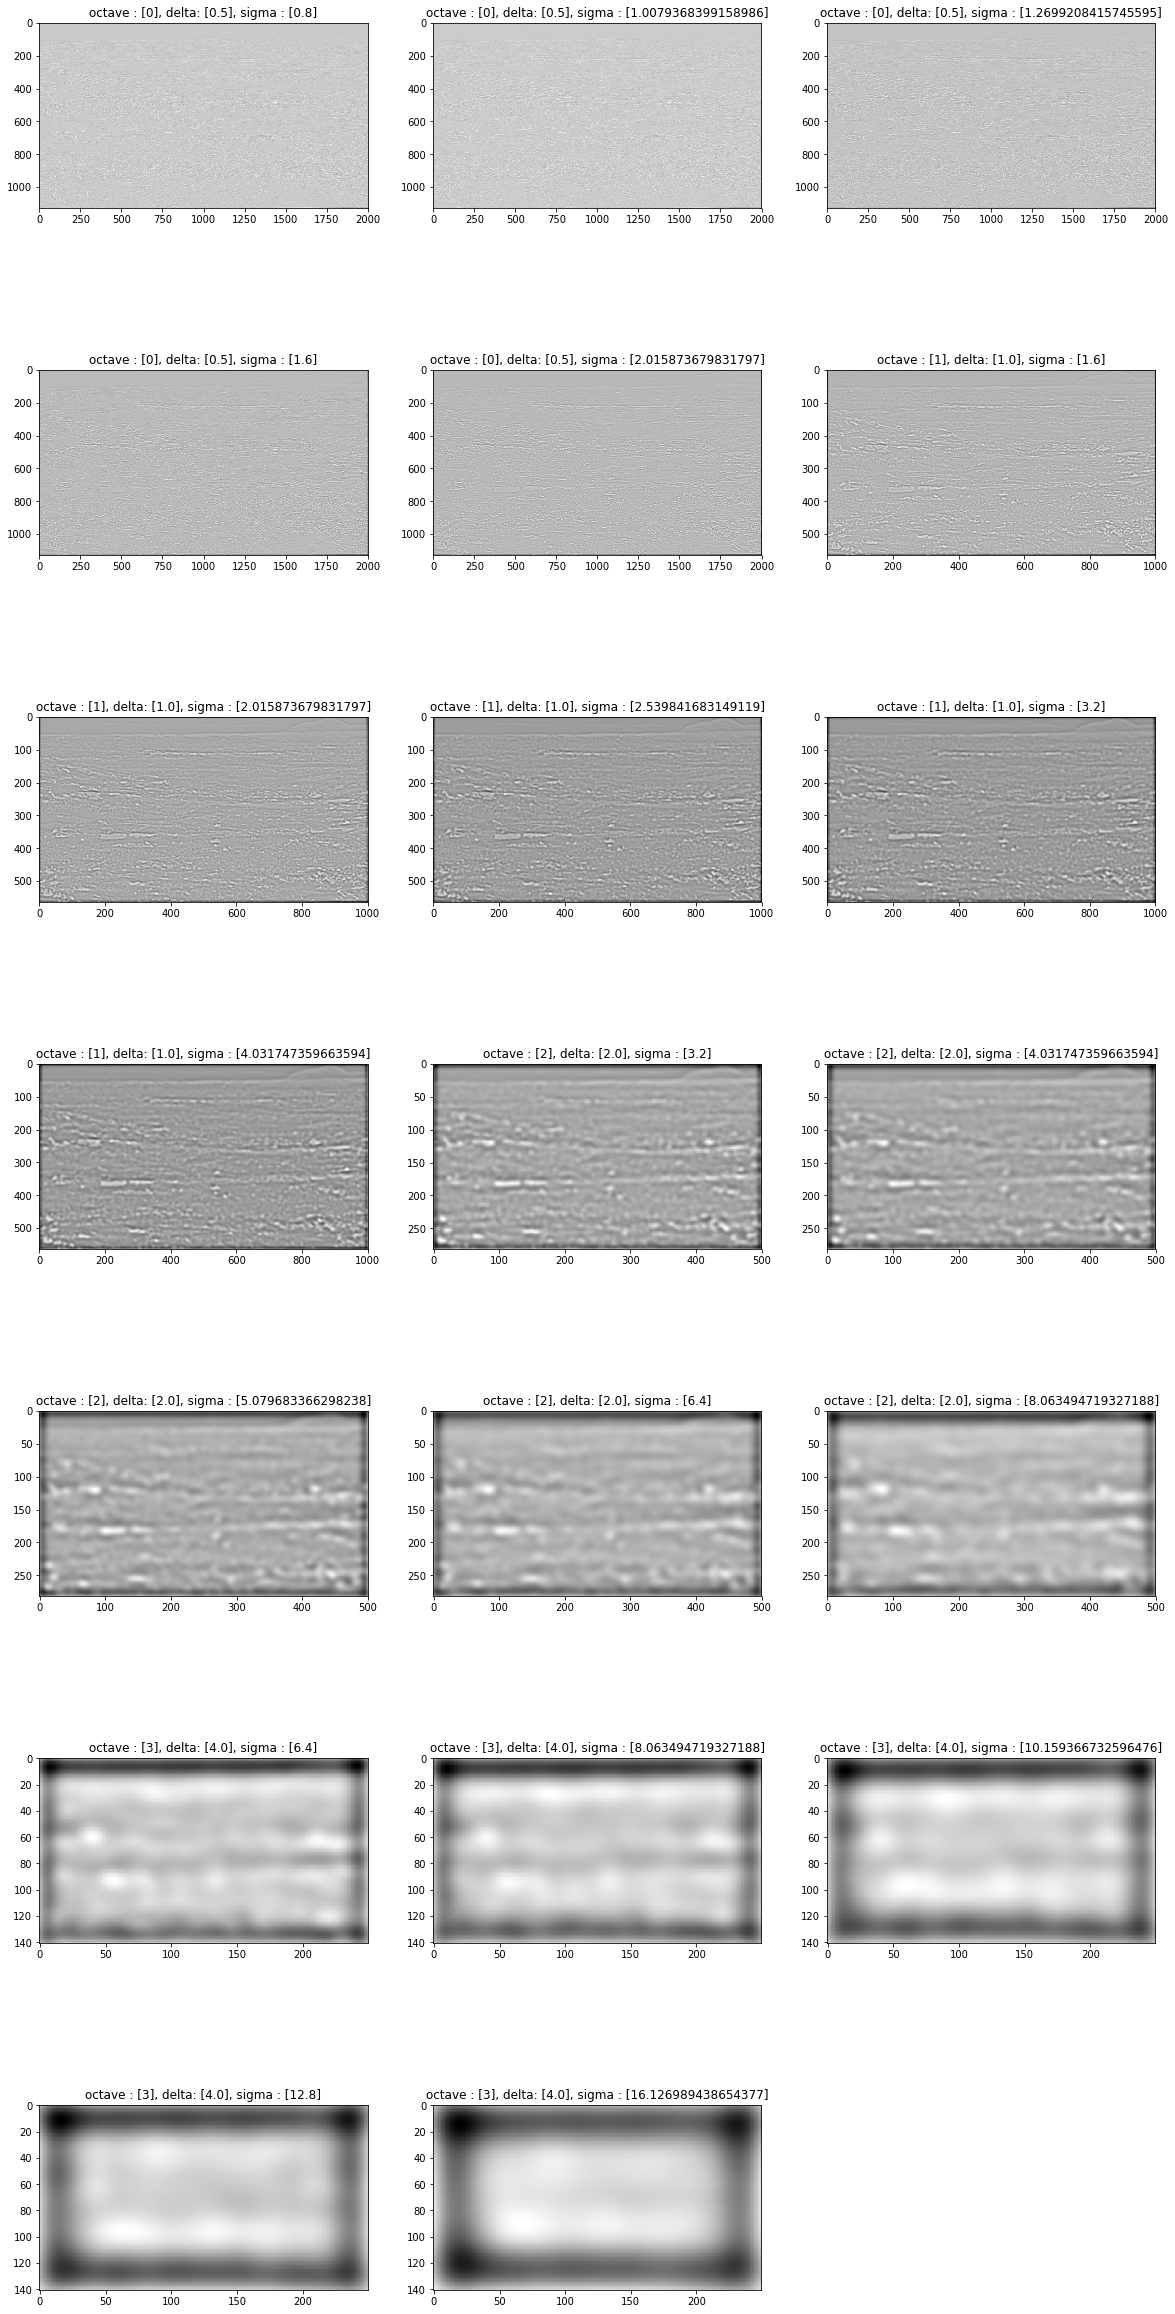

In [2]:
display(HTML('<h1>Q3. Difference de gaussiennes</h1>'))
fig = plt.figure(figsize=(20,50))   
count = 0
for i in range(n_oct):
    for j in range(len(dog[0])):
        title = "octave : [" + str(i) + "], delta: [" + str(deltas[i]) + "], sigma : [" + str(sigmas[i][j]) + "]"
        sub = fig.add_subplot(n_oct * 2, int(np.ceil((n_spo + 2) / 2)), count + 1)
        sub.set_title(title)
        sub.imshow(dog[i][j], interpolation='nearest', cmap='gray')
        count += 1

In [3]:
def keypoints_stats(keypoints, title, showgraph=False):
    print('\n',title)
    counter = np.zeros(shape=(n_oct)).astype(int)
    for keypoint in keypoints:
        counter[keypoint.octave] += 1
    for i in range(n_oct):
        print("[Octave %d]" % (i))
        print("> nombre de keypoints retenus:\t%d" % (counter[i]))
    if showgraph:
        plt.figure(figsize=(10,5))
        plt.grid(True)
        plt.xlabel('octave')
        plt.ylabel('nombre de keypoints')
        plt.title("nombre de keypoints dans chaque octave", fontsize=20)
        x = np.arange(n_oct)
        plt.plot(x, counter, 'bo')
        plt.xticks(np.arange(min(x), max(x)+1, 1.0))
        plt.show();

In [4]:
extremum = namedtuple("keypoint", ["pix_x", "pix_y", "scale", "octave", "original_x", "original_y", "sigma", "value"])

## keypoints default values
c_edge = 10
c_dog = 10

# To make the threshold independent of the scalespace discretization along scale (number of scale per octave).
# the reference is at n_spo = 3
def convert_threshold(c_dog):
    k_nspo = np.exp(np.log(2) / n_spo)
    k_3 = np.exp(np.log(2) / 3.)
    c_dog = (k_nspo - 1) / (k_3 - 1) * c_dog
    return c_dog

def adjust_c_edge(c_edge):
    return ((c_edge + 1) ** 2) / c_edge

def extremum_local(dogs, m, n):
    min_local = True
    max_local = True
    for i in range(-1, 2):
        for j in range(-1, 2):
            for k in range(-1, 2):
                if(i == 0 and j == 0 and k == 0):
                    pass
                else:
                    if dogs[1][m][n] >= dogs[1+i][m+j][n+k]:
                        min_local = False
                    elif dogs[1][m][n] < dogs[1+i][m+j][n+k]:
                        max_local = False
                if not (min_local or max_local):
                    return False
                    
    return True

def generateExtrema(dogs, sigmas):
    # loop octaves
    for i in range(len(dogs)):
        # loop scales
        for j in range(1, len(dogs[i]) - 1):
            dim_y, dim_x = dogs[i][j].shape
            # loop width
            for m in range (1, dim_y - 1):
                # loop height
                for n in range (1, dim_x - 1):
                    # comapre pixel at [m,n] to the 3x3x3 box around itself
                    if extremum_local(dogs[i][j-1:j+2], m, n):      
                        yield extremum(n, m, j, i, int(deltas[i] * n), int(deltas[i] * m), sigmas[i][j], dogs[i][j][m][n])

def hessian_2d(scale, x, y):
    h_xx = scale[y+1][x] + scale[y-1][x] - (2 * scale[y][x])
    h_yy = scale[y][x+1] + scale[y][x-1] - (2 * scale[y][x])
    h_xy = (scale[y+1][x+1] - scale[y+1][x-1] - scale[y-1][x+1] + scale[y-1][x-1]) / 4.
    return np.array([[h_xx, h_xy],[h_xy, h_yy]])

def detectionPointsCles(dogs, octaves, sigmas, thresh, c_edge, res_octave):
    keypoints = []
    tmp_keypoints = []
    extremas = []
    
    for extremum in generateExtrema(dogs, sigmas):
        extremas.append(extremum)
        if abs(extremum.value) >= thresh:
            keypoints.append(extremum)
            
    keypoints_stats(extremas, "Nombre d'extremas detectes:")
    keypoints_stats(keypoints, "Nombre d'extremas restants apres filtrage des points de faible contraste:")
    for key in keypoints:
        hess = hessian_2d(dogs[key.octave][key.scale], key.pix_x, key.pix_y)
        det = np.linalg.det(hess)
        if abs(det) > 0 and ((np.trace(hess) ** 2) / det) < c_edge :
            tmp_keypoints.append(key)
    keypoints_stats(tmp_keypoints, "Nombre d'extremas restants apres filtrage des points d'arret:")
    
    keypoints = tmp_keypoints        
    return keypoints

In [5]:
def gradient_2d(octaves):
    gradient_octaves_x = []
    gradient_octaves_y = []
    for i in range(len(octaves)):
        gradient_octaves_x.append([])
        gradient_octaves_y.append([])
        for j in range(len(octaves[i])):
            gradient_octaves_x[i].append(np.zeros(shape=octaves[i][j].shape))
            gradient_octaves_y[i].append(np.zeros(shape=octaves[i][j].shape))
            dim_y, dim_x = octaves[i][j].shape
            for m in range(1, dim_y - 1):
                for n in range(1, dim_x - 1):
                    gradient_octaves_x[i][j][m][n] = (octaves[i][j][m+1][n] - octaves[i][j][m-1][n]) / 2.
                    gradient_octaves_y[i][j][m][n] = (octaves[i][j][m][n+1] - octaves[i][j][m][n-1]) / 2.
                    
    return (gradient_octaves_x, gradient_octaves_y)

In [6]:
lambda_ori = 1.5
n_bins = 36

def compute_reference_orientation(octaves, keypoints, gradient_x, gradient_y):
    ret_keypoints = []
    ret_orientations = []
    for keypoint in keypoints:
        dim_y, dim_x = octaves[keypoint.octave][keypoint.scale].shape
        x = keypoint.original_x
        y = keypoint.original_y
        delta = deltas[keypoint.octave]
    
        # remove 3.0 and labda set to 1.0
        sl3 = 3.0 * lambda_ori * keypoint.sigma
        if (sl3 <= x and x <= dim_x * delta - sl3) and (sl3 <= y and y <= dim_y * delta - sl3):
            hist = np.zeros(shape=n_bins)
            for m in range(int((y - sl3) / delta) , int((y + sl3) / delta) + 1):
                for n in range(int((x - sl3) / delta) , int((x + sl3) / delta) + 1):
                    # contribution
                    gx = gradient_x[keypoint.octave][keypoint.scale][m][n]
                    gy = gradient_y[keypoint.octave][keypoint.scale][m][n]
                    exp_factor = np.exp(-(((m * delta - y) ** 2 + (n * delta - x) ** 2) / (2 * (lambda_ori * keypoint.sigma) ** 2)))
                    c = exp_factor * np.hypot(gx, gy)
                    # corresponding bin
                    b = int((n_bins / (2 * np.pi)) * (np.arctan2(gx, gy) % (2 * np.pi)))
                    # update histogram corresponding bin
                    hist[b] += c
                       
            #smooth histogram
            for l in range(6):
                tmp_hist = np.copy(hist)
                for i in range(n_bins):
                    i_prev = (i - 1 + n_bins) % n_bins
                    i_next = (i + 1) % n_bins
                    hist[i] = (tmp_hist[i_prev] + tmp_hist[i] + tmp_hist[i_next]) / 3.

            orientation = []
            hist_max = max(hist)
            for i in range(n_bins):
                i_prev = (i - 1 + n_bins) % n_bins
                i_next = (i + 1) % n_bins
                val = hist[i]
                val_prev = hist[i_prev]
                val_next = hist[i_next]
                if(val > val_prev and val > val_next and val > hist_max * 0.8):
                    theta_k = 2 * np.pi * i / n_bins
                    theta_ref = theta_k + np.pi / n_bins * (val_prev - val_next) / (val_prev - 2 * val + val_next)
                    orientation.append(theta_ref)
            ret_orientations.append(orientation)
            ret_keypoints.append(keypoint)
            
    return (ret_keypoints, ret_orientations)

def unpack(keypoints, orientations):
    new_keypoints = []
    unpacked_orientations = []
    for i in range(len(keypoints)):
        for o in orientations[i]:
            new_keypoints.append(keypoints[i])
            unpacked_orientations.append(o)
    return (new_keypoints, unpacked_orientations)


In [7]:
n_hist = 4
n_ori = 8
lambda_descr = 6.


def range_descriptor(val, sl2, delta, dim_max):
    r = sl2 * (n_hist + 1) / n_hist
    ret_min = int((val - r) / delta)
    ret_max = int((val + r) / delta)
    if ret_min < 0:
        ret_min = 0
    if ret_max > dim_max:
        ret_max = dim_max
    return (ret_min, ret_max)


def construct_descriptors(keypoints, orientations, gradient_x, gradient_y):
    n_descr = n_hist * n_hist * n_ori
    ret_keypoints = []
    ret_orientations = []
    ret_f = []
    for i in range(len(keypoints)):
        dim_y, dim_x = octaves[keypoints[i].octave][keypoints[i].scale].shape
        x = keypoints[i].original_x
        y = keypoints[i].original_y
        sl2 = np.sqrt(2) * lambda_descr * keypoints[i].sigma
        delta = deltas[keypoints[i].octave]
        
        if (sl2 <= x and x <= dim_x * delta - sl2) and (sl2 <= y and y <= dim_y * delta - sl2):
            hist = np.zeros(shape=(n_hist, n_hist, n_ori))
            x_min, x_max = range_descriptor(x, sl2, delta, dim_x)
            y_min, y_max = range_descriptor(y, sl2, delta, dim_y)
            for m in range(y_min, y_max):
                for n in range(x_min, x_max):
                    rot_x = ((n * delta - x) * np.cos(orientations[i]) + (m * delta - y) * np.sin(orientations[i])) / keypoints[i].sigma
                    rot_y = (-(n * delta - x) * np.sin(orientations[i]) + (m * delta - y) * np.cos(orientations[i])) / keypoints[i].sigma
                    if max(abs(rot_x), abs(rot_y)) < (lambda_descr * (n_hist + 1) / n_hist):
                        gx = gradient_x[keypoints[i].octave][keypoints[i].scale][m][n]
                        gy = gradient_y[keypoints[i].octave][keypoints[i].scale][m][n]
                        theta = np.arctan2(gx, gy) - (orientations[i] % (2 * np.pi))
                        exp_factor = np.exp(-(((m * delta - y) ** 2 + (n * delta - x) ** 2) / (2 * (lambda_descr * keypoints[i].sigma) ** 2)))
                        c = exp_factor * np.hypot(gx, gy)
                
                        for s in range(n_hist):
                            x_s = ((s + 1) - (1 + n_hist) / 2) * 2 * lambda_descr / n_hist
                            if abs(x_s - rot_x) <= (2 * lambda_descr / n_hist):
                                for t in range(n_hist):
                                    y_t = ((t + 1) - (1 + n_hist) / 2) * 2 * lambda_descr / n_hist
                                    if abs(y_t - rot_y) <= (2 * lambda_descr / n_hist):
                                        for u in range(n_ori):
                                            theta_u = 2 * np.pi * ((u + 1) - 1) / n_ori
                                            if abs(theta_u - (theta % (2 * np.pi))) < (2 * np.pi / n_ori):
                                                hist[s][t][u] += ((1 - n_hist / (2 * lambda_descr) * abs(rot_x - x_s)) *
                                                                (1 - n_hist / (2 * lambda_descr) * abs(rot_y - y_t)) *
                                                                (1 - n_ori / (2 * np.pi) * abs(theta - (theta_u % ( 2 * np.pi)))) * c)
            vector_f = hist.flatten()
            norm_t = 0.2 * np.linalg.norm(vector_f)
            for l in range(len(vector_f)):
                vector_f[l] = min(vector_f[l], 0.2 * norm_t)
                norm_t = np.linalg.norm(vector_f)
                vector_f[l] = min(np.floor(512 * vector_f[l] / norm_t), 255)
            ret_f.append(vector_f.astype(np.int16))
            ret_keypoints.append(keypoints[i])
            ret_orientations.append(orientations[i])
                        
    return ret_keypoints, ret_orientations, ret_f

In [8]:
def orientations_to_npy(keypoints, orintations, prefix):
    keypoints_matrix = np.zeros(shape=(len(keypoints),4))
    for i in range(len(keypoints)):
        keypoints_matrix[i][0] = keypoints[i].original_y
        keypoints_matrix[i][1] = keypoints[i].original_x
        keypoints_matrix[i][2] = keypoints[i].scale
        keypoints_matrix[i][3] = orintations[i]
    np.set_printoptions(threshold=np.inf, linewidth=np.inf)  # turn off summarization, line-wrapping
    with open(str(prefix) + "_ori_array_to_npy.py", 'w') as f:
        f.write("import numpy as np \n")
        f.write("array = ")
        f.write(np.array2string(keypoints_matrix, separator=', '))
        f.write("\nnp.save('" + str(prefix) + "_orientations.npy', array)")

def descriptors_to_npy(keypoints, descriptors, prefix):
    keypoints_matrix = np.zeros(shape=(len(keypoints),130))
    for i in range(len(keypoints)):
        keypoints_matrix[i][0] = keypoints[i].original_y
        keypoints_matrix[i][1] = keypoints[i].original_x
        keypoints_matrix[i][2:] = descriptors[i]
    np.set_printoptions(threshold=np.inf, linewidth=np.inf)  # turn off summarization, line-wrapping
    with open(str(prefix) + "_descr_array_to_npy.py", 'w') as f:
        f.write("import numpy as np \n")
        f.write("array = ")
        f.write(np.array2string(keypoints_matrix, separator=', '))
        f.write("\nnp.save('" + str(prefix) + "_descripteurs.npy', array)")

In [9]:
def show_SIFT_image(img_name, keypoints, orientations):
    img = Image.open(img_name)
    fig,ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(20)
    for i in range(len(keypoints)):
        x = int(keypoints[i].original_x)
        y = int(keypoints[i].original_y)
        c = matplotlib.patches.Circle(xy=(x, y), radius=(keypoints[i].scale * 10), facecolor='none', edgecolor='red')
        ax.add_patch(c)
        x_length = np.cos(orientations[i]) * keypoints[i].scale * 10
        y_length = np.sin(orientations[i]) * keypoints[i].scale * 10
        a = matplotlib.patches.Arrow(x, y, x_length, y_length, color='green')
        ax.add_patch(a)
    plt.imshow(img)

In [10]:
def compute_SIFT_image(img_name):
    img = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
    octaves, sigmas, dog, deltas = differenceDeGaussiennes(img, n_spo, n_oct)
    thresh = convert_threshold(c_dog)
    keypoints = detectionPointsCles(dog, octaves, sigmas, thresh, adjust_c_edge(c_edge), 0)
    gradient_octaves_x, gradient_octaves_y = gradient_2d(octaves)
    keypoints, orientations = compute_reference_orientation(octaves, keypoints, gradient_octaves_x, gradient_octaves_y)
    keypoints, orientations = unpack(keypoints, orientations)
    keypoints, orientations, descriptors = construct_descriptors(keypoints,orientations,gradient_octaves_x, gradient_octaves_y)
    keypoints_stats(keypoints, "nombre de keypoints conserve dans chaque octave", showgraph=True)
    descriptors_to_npy(keypoints, descriptors, img_name.split('.')[0])
    orientations_to_npy(keypoints, orientations, img_name.split('.')[0])
    show_SIFT_image(img_name, keypoints, orientations)
    return keypoints, orientations, descriptors


 Nombre d'extremas detectes:
[Octave 0]
> nombre de keypoints retenus:	43247
[Octave 1]
> nombre de keypoints retenus:	2700
[Octave 2]
> nombre de keypoints retenus:	122
[Octave 3]
> nombre de keypoints retenus:	14

 Nombre d'extremas restants apres filtrage des points de faible contraste:
[Octave 0]
> nombre de keypoints retenus:	297
[Octave 1]
> nombre de keypoints retenus:	112
[Octave 2]
> nombre de keypoints retenus:	9
[Octave 3]
> nombre de keypoints retenus:	3

 Nombre d'extremas restants apres filtrage des points d'arret:
[Octave 0]
> nombre de keypoints retenus:	28
[Octave 1]
> nombre de keypoints retenus:	38
[Octave 2]
> nombre de keypoints retenus:	7
[Octave 3]
> nombre de keypoints retenus:	3

 nombre de keypoints conserve dans chaque octave
[Octave 0]
> nombre de keypoints retenus:	0
[Octave 1]
> nombre de keypoints retenus:	11
[Octave 2]
> nombre de keypoints retenus:	3
[Octave 3]
> nombre de keypoints retenus:	0


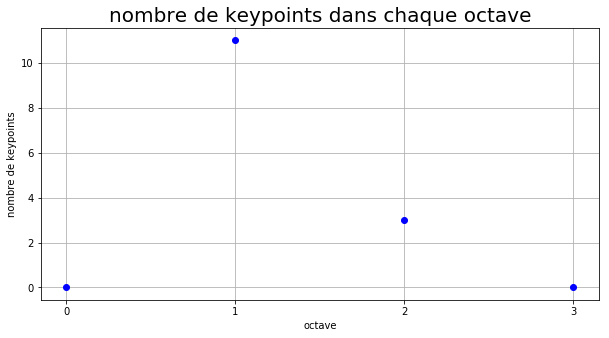

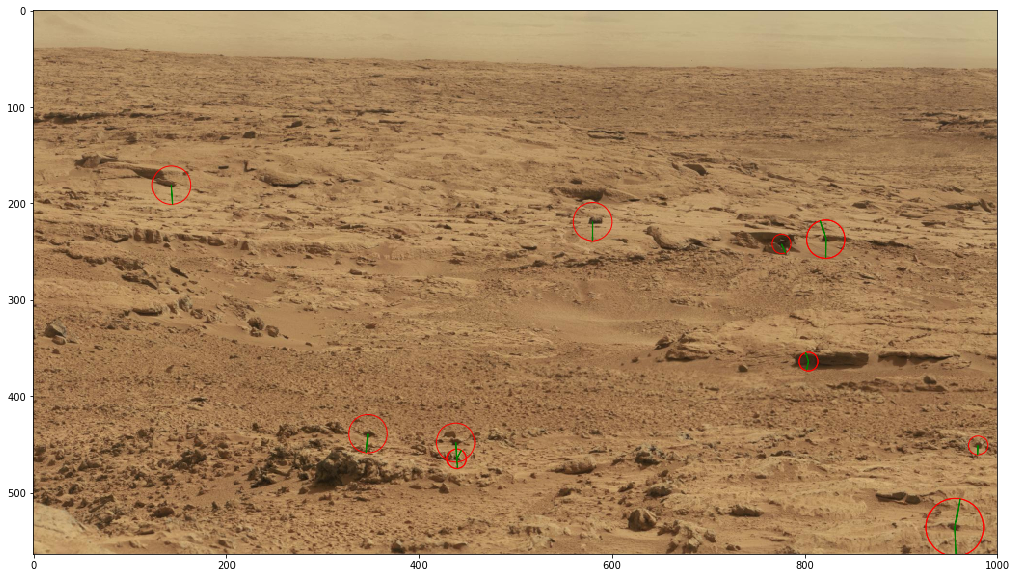

In [11]:
key_left, ori_left, descr_left = compute_SIFT_image('gauche.jpg')


 Nombre d'extremas detectes:
[Octave 0]
> nombre de keypoints retenus:	44620
[Octave 1]
> nombre de keypoints retenus:	2632
[Octave 2]
> nombre de keypoints retenus:	143
[Octave 3]
> nombre de keypoints retenus:	17

 Nombre d'extremas restants apres filtrage des points de faible contraste:
[Octave 0]
> nombre de keypoints retenus:	474
[Octave 1]
> nombre de keypoints retenus:	159
[Octave 2]
> nombre de keypoints retenus:	14
[Octave 3]
> nombre de keypoints retenus:	4

 Nombre d'extremas restants apres filtrage des points d'arret:
[Octave 0]
> nombre de keypoints retenus:	39
[Octave 1]
> nombre de keypoints retenus:	57
[Octave 2]
> nombre de keypoints retenus:	11
[Octave 3]
> nombre de keypoints retenus:	3

 nombre de keypoints conserve dans chaque octave
[Octave 0]
> nombre de keypoints retenus:	0
[Octave 1]
> nombre de keypoints retenus:	18
[Octave 2]
> nombre de keypoints retenus:	2
[Octave 3]
> nombre de keypoints retenus:	0


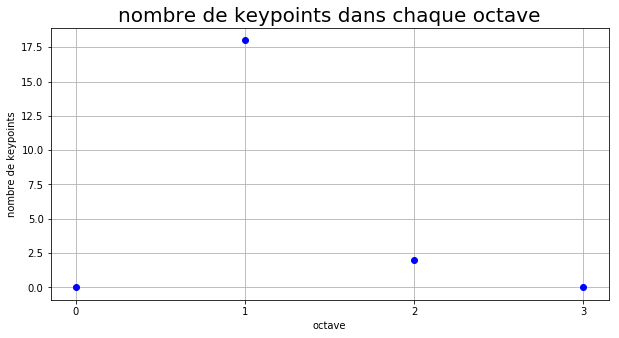

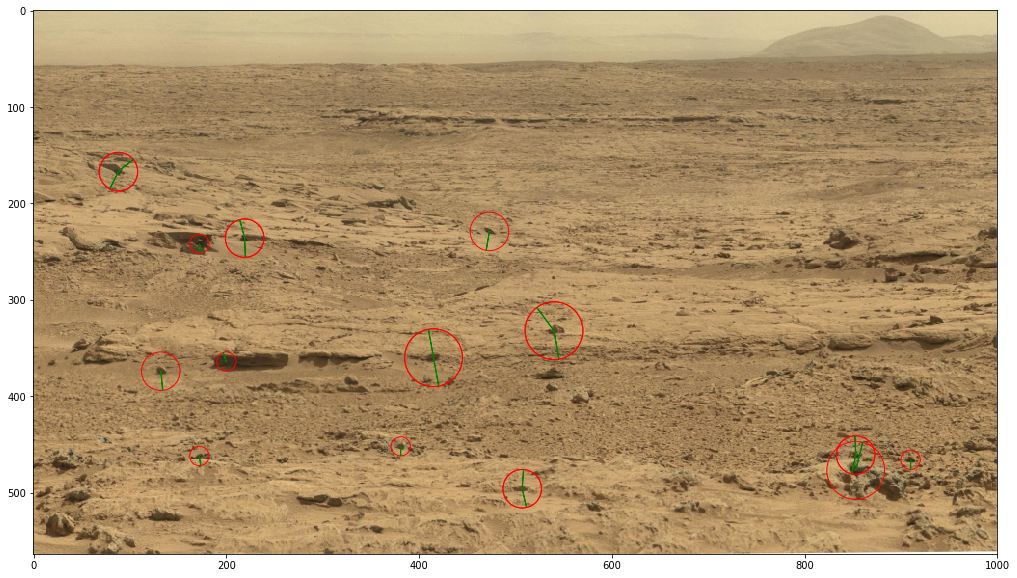

In [12]:
key_right, ori_right, descr_right = compute_SIFT_image('droite.jpg')

In [13]:
dist_thresh = 200

def distanceInterPoints(descr1, descr2):
    distances = np.zeros(shape=(len(descr1),len(descr2)))
    for i in range(len(descr1)):
        for j in range(len(descr2)):
            sum_d = 0
            for k in range(128):
                sum_d += (descr1[i][k] - descr2[j][k]) ** 2
            distances[i][j] = np.sqrt(sum_d)
    return distances


# Bareme Q1
distances = distanceInterPoints(descr_left, descr_right)


# Bareme Q2
mins = np.min(distances, axis=-1)
def get_matching_keypoints(distances, mins, thresh):
    n_min = 0
    matching_couples = []
    len_descr1, len_descr2 = distances.shape
    for i in range(len_descr1):
        for j in range(len_descr2):
            if distances[i][j] == mins[n_min]:
                if mins[n_min] < thresh:
                    matching_couples.append((i,j))
                n_min += 1
                break
    return matching_couples

matching_couples = get_matching_keypoints(distances, mins, dist_thresh)


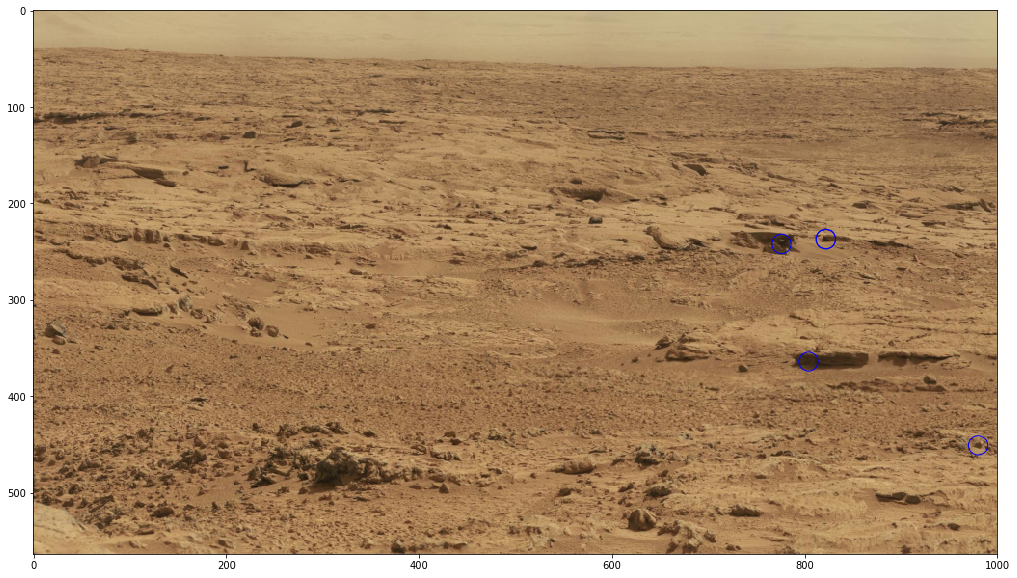

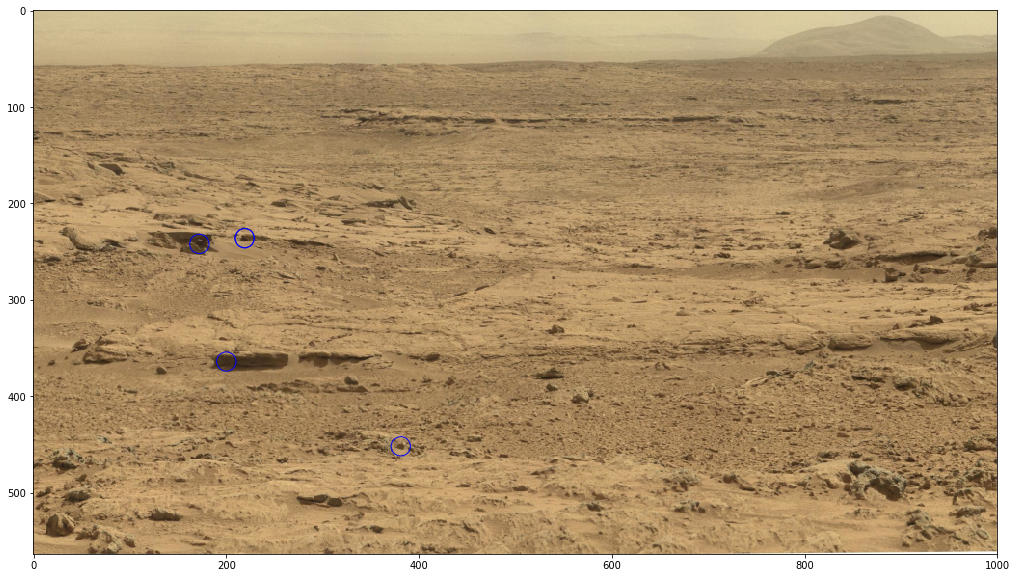

In [14]:
def show_matched_points(image_path, keypoints, matches):
    img = Image.open(image_path)
    fig,ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(20)
    for match_id in matches:
        keypoint = keypoints[match_id]
        x = int(keypoint.original_x)
        y = int(keypoint.original_y)
        c = matplotlib.patches.Circle(xy=(x, y), radius=10, facecolor='none', edgecolor='blue')
        ax.add_patch(c)
    plt.imshow(img)

show_matched_points('gauche.jpg', key_left, [i[0] for i in matching_couples])
show_matched_points('droite.jpg', key_right, [i[1] for i in matching_couples])